### Working with already created model and coefficients
Cuando trabajamos con un modelo y coeficientes ya generados, es mas sencillo

In [377]:
import pyEXP
import EXPtools
import h5py
import numpy as np

In [378]:
"""
Version information
-----------------------
Version:          EXP 7.7.28
Repository URL:   https://github.com/EXP-code/EXP
GIT branch:       pyEXPfix
GIT commit:       50566b3ff70eb6debf3bf62d814ce9db7694a8c9
Compile time:     2024-03-28 13:07:55 UTC
"""
R99 = 689.28

In [379]:
model = 'Hernquist'
Hern_config = EXPtools.basis_builder.basis_utils.make_config('sphereSL',lmax=6,nmax=20,
                                             modelname=f'{model}_model.txt',cachename=f'{model}_halo.cache',
                                             numr=500, rmin=2.5, rmax=R99, scale=1)
Hern_basis = pyEXP.basis.Basis.factory(Hern_config)
Hern_coefs = pyEXP.coefs.Coefs.factory('Hernquist_halo.h5')

In [380]:
model = 'NFW'
NFW_config = EXPtools.basis_builder.basis_utils.make_config('sphereSL',lmax=6,nmax=20,
                                             modelname=f'{model}_model.txt',cachename=f'{model}_halo.cache',
                                             numr=500, rmin=2.5, rmax=R99, scale=1)
NFW_basis = pyEXP.basis.Basis.factory(NFW_config)
NFW_coefs = pyEXP.coefs.Coefs.factory('NFW_halo.h5')

---- SLGridSph::ReadH5Cache: parameter numr: wanted 500 found 200
---- SLGridSph::WriteH5Cache cache file <Hernquist_halo.cache> exists
---- SLGridSph::WriteH5Cache: existing file backed up to <Hernquist_halo.cache.bak>
---- SLGridSph::WriteH5Cache: wrote <Hernquist_halo.cache>
SphericalSL::orthoTest: worst=0.00774314
---- SLGridSph::ReadH5Cache: successfully read basis cache <NFW_halo.cache>
SphericalSL::orthoTest: worst=0.0986616


Text(0.5, 0.98, 'Orthogonal tests')

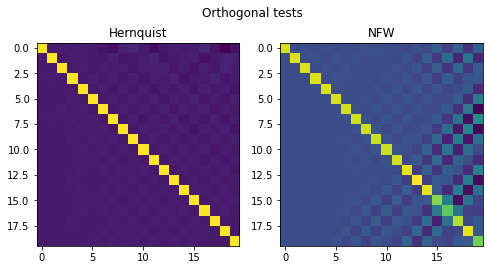

In [453]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(Hern_basis.orthoCheck()[0])
ax[1].imshow(NFW_basis.orthoCheck()[0])
ax[0].set_title('Hernquist')
ax[1].set_title('NFW')

fig.suptitle('Orthogonal tests')

#### Extraccion de perfiles de las bases

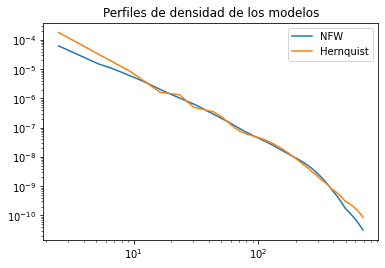

In [455]:
field = 'dens'

rad_NFW, field_dens_NFW = EXPtools.visuals.visualize.spherical_avg_prop(NFW_basis,NFW_coefs, rmin=2.5, rmax=R99, nbins=500, log_space=False, time=0, property=field,
                                                                        include_monopole=False)
rad_Hern, field_dens_Hern = EXPtools.visuals.visualize.spherical_avg_prop(Hern_basis,Hern_coefs, rmin=2.5, rmax=R99, nbins=100, log_space=False, time=0, property=field,
                                                                          include_monopole=False)
plt.plot(rad_NFW, field_dens_NFW, label='NFW')
plt.plot(rad_Hern, field_dens_Hern, label='Hernquist')
plt.xscale('log')
plt.yscale('log')
plt.title('Perfiles de densidad de los modelos')
plt.legend()

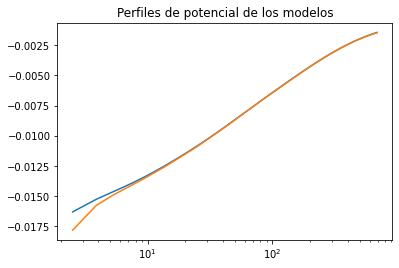

In [456]:
field = 'pot'

rad_NFW, field_pot_NFW = EXPtools.visuals.visualize.spherical_avg_prop(NFW_basis,NFW_coefs, rmin=2.5, rmax=R99, nbins=500, log_space=False, time=0, property=field, include_monopole=False)
rad_Hern, field_pot_Hern = EXPtools.visuals.visualize.spherical_avg_prop(Hern_basis,Hern_coefs, rmin=2.5, rmax=R99, nbins=500, log_space=False, time=0, property=field, include_monopole=False)
plt.plot(rad_NFW, field_pot_NFW)
plt.plot(rad_Hern, field_pot_Hern)
plt.title('Perfiles de potencial de los modelos')
plt.xscale('log')

### Comparing with empirical values

In [392]:
id = 372754
# Obtained from the header file
HubbleParam  =  0.6774
Omega0  =  0.3089
OmegaLambda  =  0.6911
Redshift  =  2.220446049250313e-16
Time  =  0.9999999999999998 # Is also defined as the scale factor a, since z~0, a~1
with h5py.File(f"subhalo_{id}.hdf5", "r") as file:
    print(file['99/dm'].keys())
    pos = np.array(file['99/dm/Coordinates_centered'])
    radius = np.array(file['99/dm/Distance_to_center'])
    mass = np.full(pos.shape[0],3.1e5/HubbleParam)

<KeysViewHDF5 ['Coordinates', 'Coordinates_centered', 'Distance_to_center', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'Velocities', 'count']>


In [393]:
bins = 500
rmin, rmax = rad_NFW[0],rad_NFW[-1]
rbins = np.linspace(rmin,rmax,bins)

In [394]:
R = np.linalg.norm(pos,axis=1)
max(R)
filtr = np.where((R < rmax) & (R > rmin))[0]

In [395]:
emp_dens = EXPtools.basis_builder.makemodel.empirical_density_profile(rbins,pos[filtr],mass[filtr]/sum(mass[filtr]))

(None, None, Text(0, 0.5, 'mass density'), Text(0.5, 0, 'Radius(kpc)'))

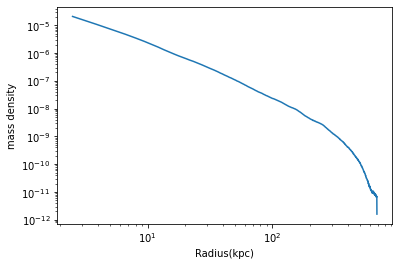

In [396]:
plt.plot(rbins[:-1],emp_dens)
plt.xscale('log'),plt.yscale('log'),plt.ylabel('mass density'),plt.xlabel('Radius(kpc)')

#### Modelos base en comparacion al empirico

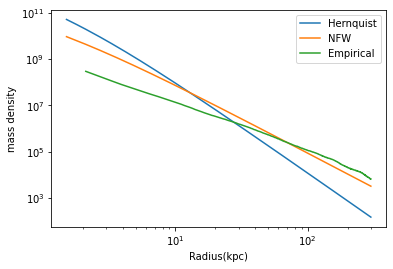

In [71]:
# Comparando con orden cero
emp_dens_nonorm = EXPtools.basis_builder.makemodel.empirical_density_profile(rbins,pos,mass)

fig, ax = plt.subplots(1,1,figsize=(6,4))

read_model = np.loadtxt('Hernquist_model.txt', skiprows=3)
ax.plot(read_model[:,0],read_model[:,1], label='Hernquist')
ax.set_xscale('log')
ax.set_yscale('log')

read_model = np.loadtxt('NFW_model.txt', skiprows=3)
ax.plot(read_model[:,0],read_model[:,1], label='NFW')

ax.plot(rbins[1:],emp_dens_nonorm, label='Empirical')
ax.set_xscale('log'),ax.set_yscale('log'),ax.set_ylabel('mass density'),ax.set_xlabel('Radius(kpc)')

ax.legend()

#### Ahora utilizando los perfiles de las bases
comparando perfil empirico con el obtenido de la expansion completa

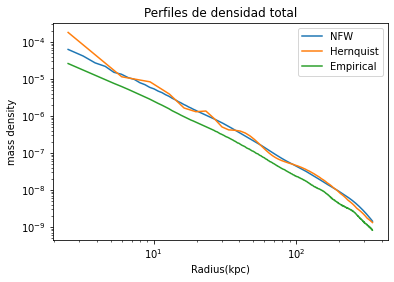

In [463]:
rbins = np.linspace(rmin,0.5*R99,bins)
emp_dens = EXPtools.basis_builder.makemodel.empirical_density_profile(rbins,pos[filtr],mass[filtr]/sum(mass[filtr]))
rad_NFW, field_dens_NFW = EXPtools.visuals.visualize.spherical_avg_prop(NFW_basis,NFW_coefs, rmin=2.5, rmax=0.5*R99, nbins=500, log_space=False, time=0, property='dens',
                                                                        include_monopole=False)
rad_Hern, field_dens_Hern = EXPtools.visuals.visualize.spherical_avg_prop(Hern_basis,Hern_coefs, rmin=2.5, rmax=0.5*R99, nbins=100, log_space=False, time=0, property='dens',
                                                                          include_monopole=False)

fig, ax = plt.subplots(1,1,figsize=(6,4))


ax.plot(rad_NFW[:], field_dens_NFW[:], label='NFW')
ax.plot(rad_Hern, field_dens_Hern, label='Hernquist')
ax.plot(rbins[:-1],emp_dens, label='Empirical')

ax.set_xscale('log'),ax.set_yscale('log'),ax.set_ylabel('mass density'),ax.set_xlabel('Radius(kpc)')
ax.set_title('Perfiles de densidad total')
ax.legend()

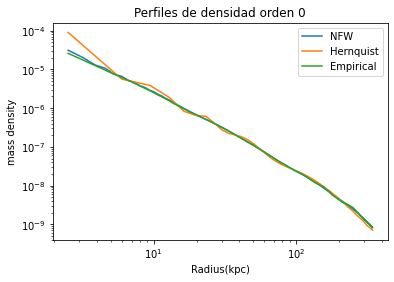

In [464]:
rbins = np.linspace(rmin,0.5*R99,bins)
emp_dens = EXPtools.basis_builder.makemodel.empirical_density_profile(rbins,pos[filtr],mass[filtr]/sum(mass[filtr]))
rad_NFW, field_dens_NFW = EXPtools.visuals.visualize.spherical_avg_prop(NFW_basis,NFW_coefs, rmin=2.5, rmax=0.5*R99, nbins=500, log_space=False, time=0, property='dens',
                                                                        include_monopole=True)
rad_Hern, field_dens_Hern = EXPtools.visuals.visualize.spherical_avg_prop(Hern_basis,Hern_coefs, rmin=2.5, rmax=0.5*R99, nbins=100, log_space=False, time=0, property='dens',
                                                                          include_monopole=True)

fig, ax = plt.subplots(1,1,figsize=(6,4))


ax.plot(rad_NFW[:], field_dens_NFW[:], label='NFW')
ax.plot(rad_Hern, field_dens_Hern, label='Hernquist')
ax.plot(rbins[:-1],emp_dens, label='Empirical')

ax.set_xscale('log'),ax.set_yscale('log'),ax.set_ylabel('mass density'),ax.set_xlabel('Radius(kpc)')
ax.set_title('Perfiles de densidad orden 0')
ax.legend()

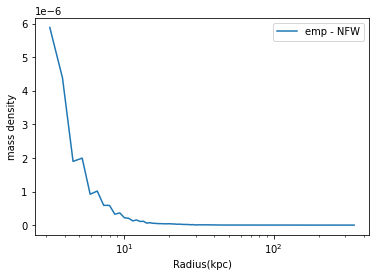

In [450]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(rbins[1:],emp_dens - field_dens_NFW[1:], label='emp - NFW')

ax.set_xscale('log'),ax.set_ylabel('mass density'),ax.set_xlabel('Radius(kpc)')
ax.legend()

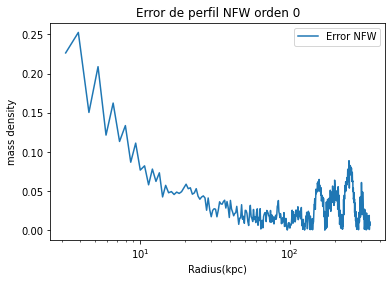

In [467]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(rbins[1:],abs(emp_dens[:] - field_dens_NFW[1:])/emp_dens[:], label='Error NFW')

ax.set_xscale('log'),ax.set_ylabel('mass density'),ax.set_xlabel('Radius(kpc)')#,ax.set_yscale('log')
ax.set_title('Error de perfil NFW orden 0')
ax.legend()

#### Comparando slices de Hernquist y NFW

In [409]:
def empirical_slice(pos, mass,
                    projection='XY', proj_plane=0, Lz= 1e-1,
                    npoints=300, grid_limits=(-300,300),
                    prop='dens'):
    if projection not in ['XY','XZ','YZ']:
        raise valueError('Invalid Projection, must be XY, XZ , or YZ')
    if projection == 'XY':
        in_slice = np.where(abs(pos[:,2]) < proj_plane+Lz)[0]
    elif projection == 'XZ':
        in_slice = np.where(abs(pos[:,1]) < proj_plane+Lz)[0]
    elif projection == 'YZ':
        in_slice = np.where(abs(pos[:,0]) < proj_plane+Lz)[0]
    pos_slice,mass_slice = pos[in_slice,:],mass[in_slice]
    print(pos_slice.shape)
    rho, xbins, ybins = np.histogram2d(pos_slice[:,0],pos_slice[:,1],bins=npoints, weights=mass_slice**-1,
                                       range=[[grid_limits[0],grid_limits[1]],[grid_limits[0],grid_limits[1]]])
    rho = rho/Lz
    return (xbins[0:-1], ybins[0:-1], rho)

In [410]:
x = np.linspace(-300,300,300)
xgrid = np.meshgrid(x,x)

In [411]:
xgrid[0]

array([[-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ],
       [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ],
       [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ],
       ...,
       [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ],
       [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ],
       [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ]])

(784965, 3)


/tmp/ipykernel_5886/402650554.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(xbins,ybins,np.log10(rho))
/tmp/ipykernel_5886/402650554.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.contour(xbins,ybins,np.log10(rho), zorder=100, c='k')
/tmp/ipykernel_5886/402650554.py:4: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(xbins,ybins,np.log10(rho), zorder=100, c='k')


((300, 300), 0.007439163096775621)

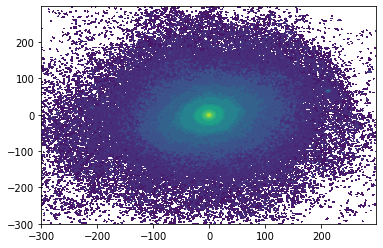

In [468]:
filtr = np.where(R < R99)
xbins, ybins, rho = empirical_slice(pos[filtr],mass[filtr], Lz=5)
plt.contourf(xbins,ybins,np.log10(rho))
plt.contour(xbins,ybins,np.log10(rho), zorder=100, c='k')
rho.shape,rho[150,150]

In [437]:
NFWdens0, NFWdens, NFWxgrid = EXPtools.visuals.visualize.slice_fields(NFW_basis,NFW_coefs)

In [438]:
Herndens0, Herndens, Hernxgrid = EXPtools.visuals.visualize.slice_fields(Hern_basis,Hern_coefs)

In [439]:
NFWdens.shape,Herndens.shape,rho.shape,NFWdens[150,150],Herndens[150,150],rho[150,150],NFWxgrid[1][1][1],Hernxgrid[1][1][1],xbins[1],ybins[1]

((300, 300),
 (300, 300),
 (300, 300),
 -2.9963886336523962e-05,
 -0.0024944623776979448,
 0.007439163096775621,
 -297.9933110367893,
 -297.9933110367893,
 -298.0,
 -298.0)

/tmp/ipykernel_5886/1990278270.py:3: RuntimeWarning: invalid value encountered in log10
  NFWcont = ax[0,0].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
/tmp/ipykernel_5886/1990278270.py:5: RuntimeWarning: invalid value encountered in log10
  ax[0,0].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
/tmp/ipykernel_5886/1990278270.py:9: RuntimeWarning: invalid value encountered in log10
  Herncont = ax[0,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
/tmp/ipykernel_5886/1990278270.py:11: RuntimeWarning: invalid value encountered in log10
  ax[0,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
/tmp/ipykernel_5886/1990278270.py:22: RuntimeWarning: divide by zero encountered in log10
  empcont = ax[1,0].contourf(xbins,ybins,np.log10(rho))
/tmp/ipykernel_5886/1990278270.py:28: RuntimeWarning: invalid value encountered in log10
  NFWcont = ax[1,1].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
/tmp/ipykernel_5886

(-300.0, 298.0, -300.0, 298.0)

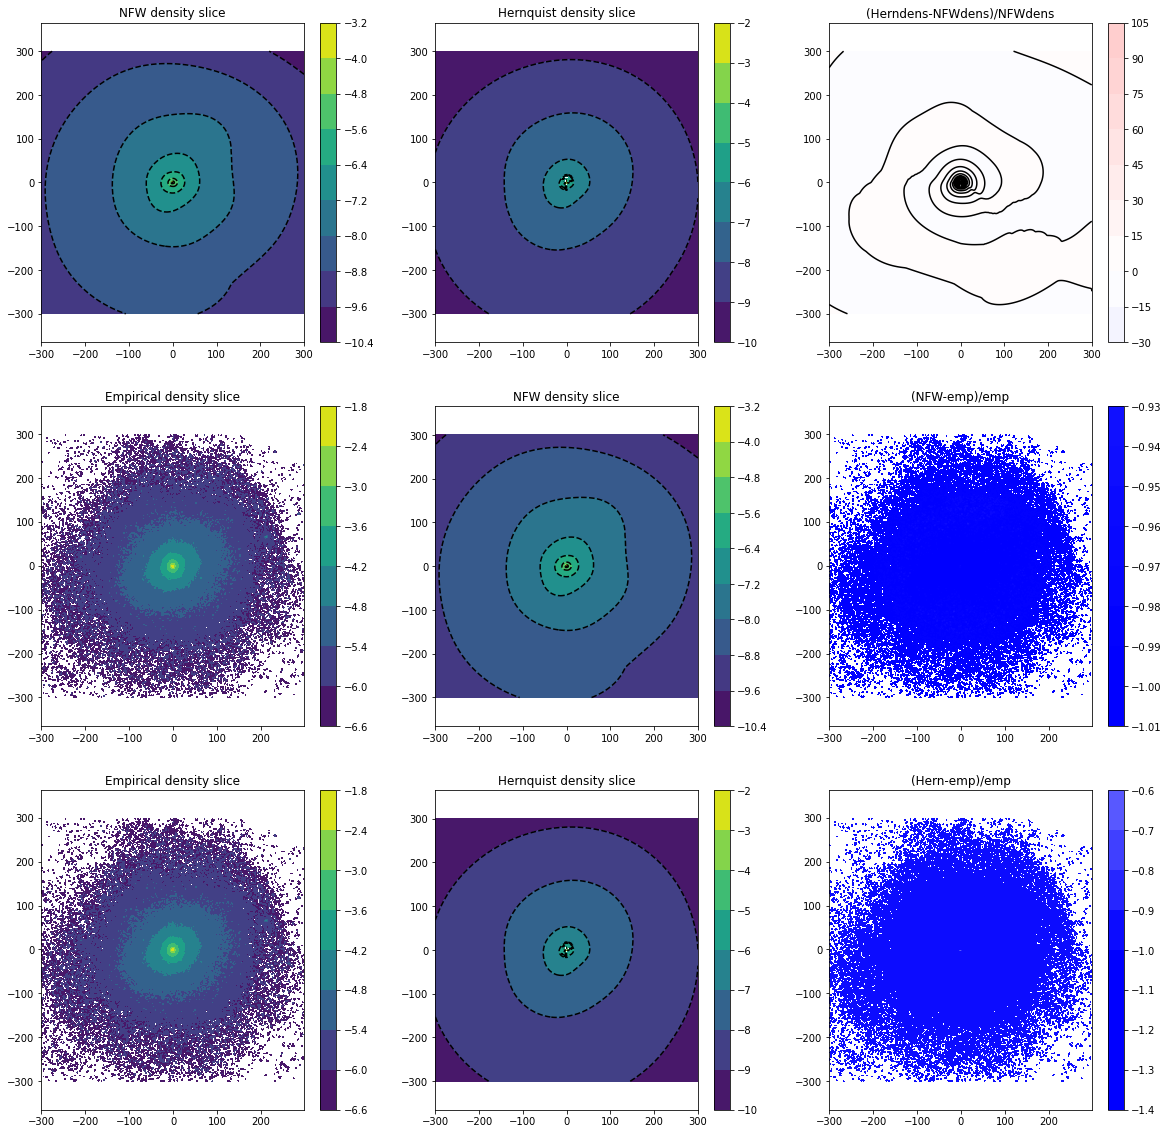

In [473]:
fig, ax = plt.subplots(3,3,figsize=(20,20))

NFWcont = ax[0,0].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
plt.colorbar(NFWcont)
ax[0,0].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
ax[0,0].set_title('NFW density slice')
ax[0,0].axis('equal')

Herncont = ax[0,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
plt.colorbar(Herncont)
ax[0,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
ax[0,1].set_title('Hernquist density slice')
ax[0,1].axis('equal')

diff = (Herndens-NFWdens)/NFWdens
diffcont = ax[0,2].contourf(Hernxgrid[0],Hernxgrid[1],diff,cmap='bwr',vmin=-500,vmax=500)
cbar = plt.colorbar(diffcont)
ax[0,2].contour(Hernxgrid[0],Hernxgrid[1],(NFWdens-Herndens)/NFWdens, zorder=100, colors='k')
ax[0,2].set_title('(Herndens-NFWdens)/NFWdens')
ax[0,2].axis('equal')

empcont = ax[1,0].contourf(xbins,ybins,np.log10(rho))
plt.colorbar(empcont)
#ax[1,0].contour(xbins,ybins,np.log10(rho), zorder=100, colors='k')
ax[1,0].set_title('Empirical density slice')
ax[1,0].axis('equal')

NFWcont = ax[1,1].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
plt.colorbar(NFWcont)
ax[1,1].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
ax[1,1].set_title('NFW density slice')
ax[1,1].axis('equal')

diff = (NFWdens-rho)/rho
diffcont = ax[1,2].contourf(xbins,ybins,diff,cmap='bwr',vmin=-1,vmax=1)
cbar = plt.colorbar(diffcont)
ax[1,2].set_title('(NFW-emp)/emp')
ax[1,2].axis('equal')

empcont = ax[2,0].contourf(xbins,ybins,np.log10(rho))
plt.colorbar(empcont)
#ax[1,0].contour(xbins,ybins,np.log10(rho), zorder=100, colors='k')
ax[2,0].set_title('Empirical density slice')
ax[2,0].axis('equal')

Herncont = ax[2,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
plt.colorbar(Herncont)
ax[2,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
ax[2,1].set_title('Hernquist density slice')
ax[2,1].axis('equal')

diff = (Herndens-rho)/rho
diffcont = ax[2,2].contourf(xbins,ybins,diff,cmap='bwr',vmin=-1,vmax=1)
cbar = plt.colorbar(diffcont)
ax[2,2].set_title('(Hern-emp)/emp')
ax[2,2].axis('equal')

/tmp/ipykernel_5886/1550729478.py:9: RuntimeWarning: invalid value encountered in log10
  Herncont = ax[0,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens0))
/tmp/ipykernel_5886/1550729478.py:11: RuntimeWarning: invalid value encountered in log10
  ax[0,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens0), zorder=100, colors='k')
/tmp/ipykernel_5886/1550729478.py:22: RuntimeWarning: divide by zero encountered in log10
  empcont = ax[1,0].contourf(xbins,ybins,np.log10(rho))
/tmp/ipykernel_5886/1550729478.py:34: RuntimeWarning: divide by zero encountered in divide
  diff = (NFWdens0-rho)/rho
/tmp/ipykernel_5886/1550729478.py:40: RuntimeWarning: divide by zero encountered in log10
  empcont = ax[2,0].contourf(xbins,ybins,np.log10(rho))
/tmp/ipykernel_5886/1550729478.py:46: RuntimeWarning: invalid value encountered in log10
  Herncont = ax[2,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens0))
/tmp/ipykernel_5886/1550729478.py:48: RuntimeWarning: invalid value encountered 

(-300.0, 298.0, -300.0, 298.0)

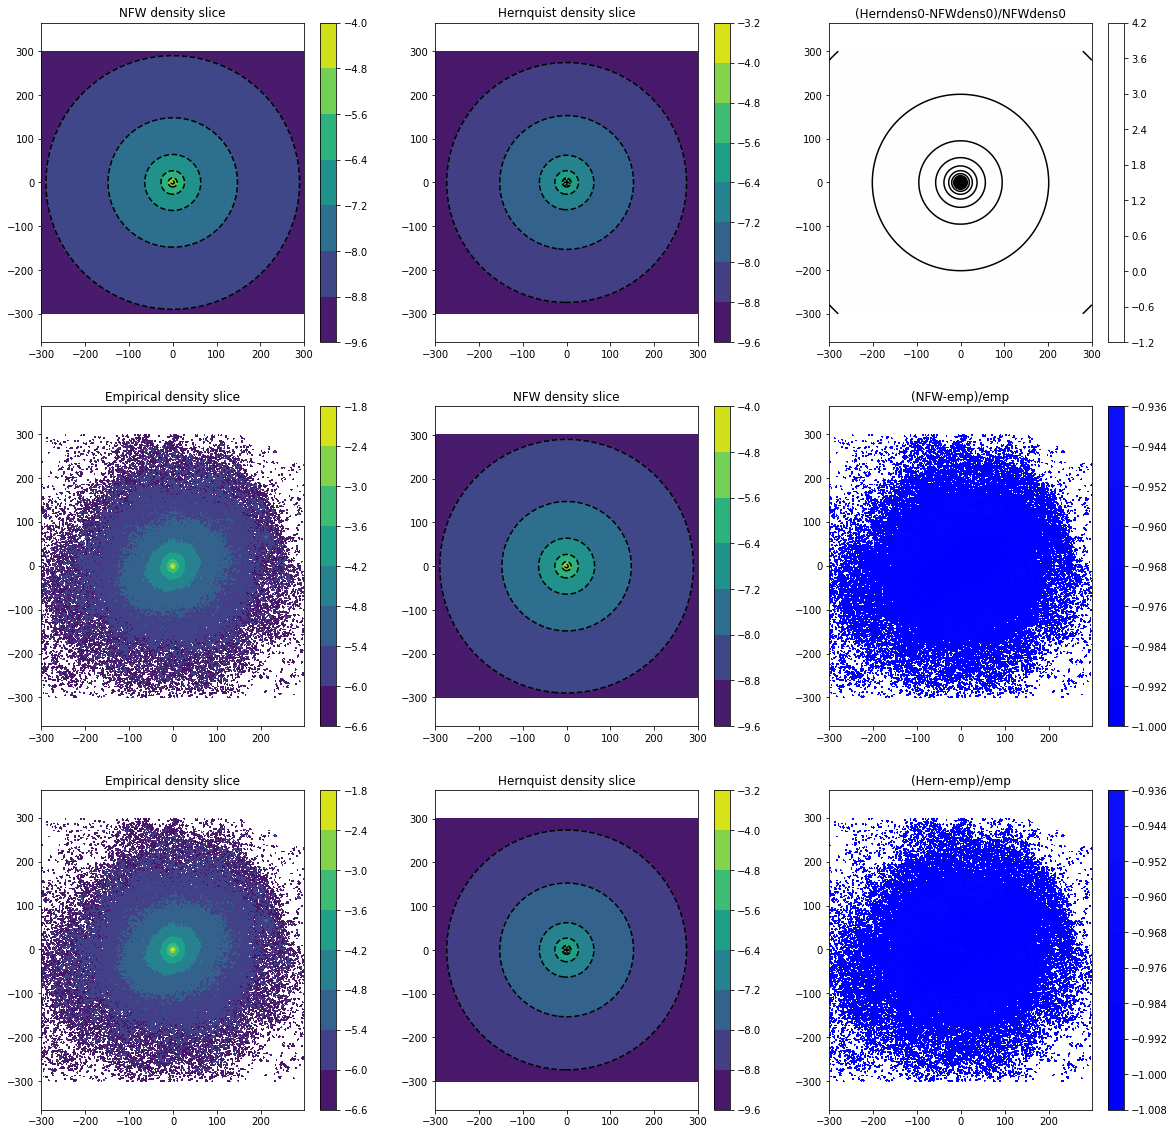

In [475]:
fig, ax = plt.subplots(3,3,figsize=(20,20))

NFWcont = ax[0,0].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens0))
plt.colorbar(NFWcont)
ax[0,0].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens0), zorder=100, colors='k')
ax[0,0].set_title('NFW density slice')
ax[0,0].axis('equal')

Herncont = ax[0,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens0))
plt.colorbar(Herncont)
ax[0,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens0), zorder=100, colors='k')
ax[0,1].set_title('Hernquist density slice')
ax[0,1].axis('equal')

diff = (Herndens0-NFWdens0)/NFWdens0
diffcont = ax[0,2].contourf(Hernxgrid[0],Hernxgrid[1],diff,cmap='bwr',vmin=-500,vmax=500)
cbar = plt.colorbar(diffcont)
ax[0,2].contour(Hernxgrid[0],Hernxgrid[1],(NFWdens0-Herndens0)/NFWdens0, zorder=100, colors='k')
ax[0,2].set_title('(Herndens0-NFWdens0)/NFWdens0')
ax[0,2].axis('equal')

empcont = ax[1,0].contourf(xbins,ybins,np.log10(rho))
plt.colorbar(empcont)
#ax[1,0].contour(xbins,ybins,np.log10(rho), zorder=100, colors='k')
ax[1,0].set_title('Empirical density slice')
ax[1,0].axis('equal')

NFWcont = ax[1,1].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens0))
plt.colorbar(NFWcont)
ax[1,1].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens0), zorder=100, colors='k')
ax[1,1].set_title('NFW density slice')
ax[1,1].axis('equal')

diff = (NFWdens0-rho)/rho
diffcont = ax[1,2].contourf(xbins,ybins,diff,cmap='bwr',vmin=-1,vmax=1)
cbar = plt.colorbar(diffcont)
ax[1,2].set_title('(NFW-emp)/emp')
ax[1,2].axis('equal')

empcont = ax[2,0].contourf(xbins,ybins,np.log10(rho))
plt.colorbar(empcont)
#ax[1,0].contour(xbins,ybins,np.log10(rho), zorder=100, colors='k')
ax[2,0].set_title('Empirical density slice')
ax[2,0].axis('equal')

Herncont = ax[2,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens0))
plt.colorbar(Herncont)
ax[2,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens0), zorder=100, colors='k')
ax[2,1].set_title('Hernquist density slice')
ax[2,1].axis('equal')

diff = (Herndens0-rho)/rho
diffcont = ax[2,2].contourf(xbins,ybins,diff,cmap='bwr',vmin=-1,vmax=1)
cbar = plt.colorbar(diffcont)
ax[2,2].set_title('(Hern-emp)/emp')
ax[2,2].axis('equal')

In [524]:
rho[100,100]+move*rho[100,100],NFWdens[100,100]

(3.680585355045872e-08, 1.1576955874341384e-08)

/tmp/ipykernel_5886/3905160822.py:5: RuntimeWarning: invalid value encountered in log10
  NFWcont = ax[0,0].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
/tmp/ipykernel_5886/3905160822.py:7: RuntimeWarning: invalid value encountered in log10
  ax[0,0].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
/tmp/ipykernel_5886/3905160822.py:11: RuntimeWarning: invalid value encountered in log10
  Herncont = ax[0,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
/tmp/ipykernel_5886/3905160822.py:13: RuntimeWarning: invalid value encountered in log10
  ax[0,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
/tmp/ipykernel_5886/3905160822.py:24: RuntimeWarning: divide by zero encountered in log10
  empcont = ax[1,0].contourf(xbins,ybins,np.log10(rho+move*rho))
/tmp/ipykernel_5886/3905160822.py:30: RuntimeWarning: invalid value encountered in log10
  NFWcont = ax[1,1].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
/tmp/ipyk

(-300.0, 298.0, -300.0, 298.0)

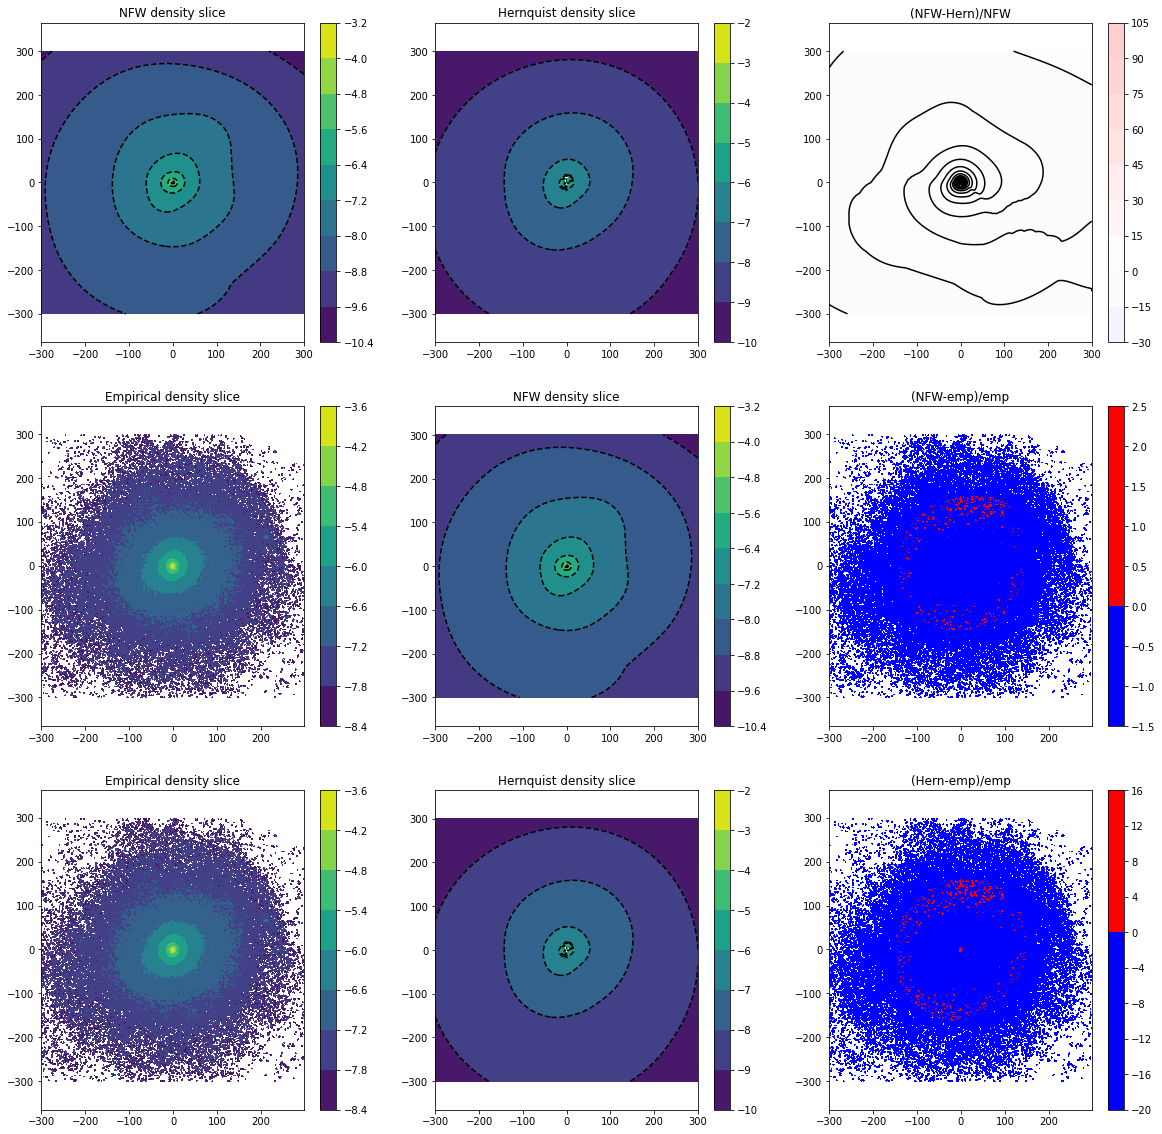

In [525]:
move = ((NFWdens.max()-rho.max())/(rho.max()))

fig, ax = plt.subplots(3,3,figsize=(20,20))

NFWcont = ax[0,0].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
plt.colorbar(NFWcont)
ax[0,0].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
ax[0,0].set_title('NFW density slice')
ax[0,0].axis('equal')

Herncont = ax[0,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
plt.colorbar(Herncont)
ax[0,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
ax[0,1].set_title('Hernquist density slice')
ax[0,1].axis('equal')

diff = (Herndens-NFWdens)/NFWdens
diffcont = ax[0,2].contourf(Hernxgrid[0],Hernxgrid[1],diff,cmap='bwr',vmin=-500,vmax=500)
cbar = plt.colorbar(diffcont)
ax[0,2].contour(Hernxgrid[0],Hernxgrid[1],(NFWdens-Herndens)/NFWdens, zorder=100, colors='k')
ax[0,2].set_title('(NFW-Hern)/NFW')
ax[0,2].axis('equal')

empcont = ax[1,0].contourf(xbins,ybins,np.log10(rho+move*rho))
plt.colorbar(empcont)
#ax[1,0].contour(xbins,ybins,np.log10(rho), zorder=100, colors='k')
ax[1,0].set_title('Empirical density slice')
ax[1,0].axis('equal')

NFWcont = ax[1,1].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
plt.colorbar(NFWcont)
ax[1,1].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
ax[1,1].set_title('NFW density slice')
ax[1,1].axis('equal')

diff = (NFWdens-(rho+move*rho))/(rho+move*rho)
diffcont = ax[1,2].contourf(xbins,ybins,diff,cmap='bwr',vmin=-5e-4,vmax=5e-4)
cbar = plt.colorbar(diffcont)
ax[1,2].set_title('(NFW-emp)/emp')
ax[1,2].axis('equal')

empcont = ax[2,0].contourf(xbins,ybins,np.log10(rho+move*rho))
plt.colorbar(empcont)
#ax[1,0].contour(xbins,ybins,np.log10(rho), zorder=100, colors='k')
ax[2,0].set_title('Empirical density slice')
ax[2,0].axis('equal')

Herncont = ax[2,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
plt.colorbar(Herncont)
ax[2,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
ax[2,1].set_title('Hernquist density slice')
ax[2,1].axis('equal')

diff = (Herndens-(rho+move*rho))/(rho+move*rho)
diffcont = ax[2,2].contourf(xbins,ybins,diff,cmap='bwr',vmin=-5e-4,vmax=5e-4)
cbar = plt.colorbar(diffcont)
ax[2,2].set_title('(Hern-emp)/emp')
ax[2,2].axis('equal')

#### hernquist test

In [65]:
model = 'hernq'
hernq_config = EXPtools.basis_builder.basis_utils.make_config('sphereSL',lmax=6,nmax=20,
                                                              modelname=f'{model}_model.txt',cachename=f'{model}_halo.cache',
                                                              numr=1000, rmin=1.5, rmax=300, scale=1)
hernq_basis = pyEXP.basis.Basis.factory(Hern_config)
hernq_coefs = pyEXP.coefs.Coefs.factory('hernq_halo.h5')

---- SLGridSph::ReadH5Cache: parameter numr: wanted 1000 found 1001
---- SLGridSph::WriteH5Cache cache file <Hernquist_halo.cache> exists
---- SLGridSph::WriteH5Cache: existing file backed up to <Hernquist_halo.cache.bak>
---- SLGridSph::WriteH5Cache: wrote <Hernquist_halo.cache>
SphericalSL::orthoTest: worst=0.00102657


In [67]:
rad_hernq, field_hernq = EXPtools.visuals.visualize.spherical_avg_prop(hernq_basis,hernq_coefs, rmin=1.5, rmax=300, nbins=500, log_space=False, time=0, property=field)

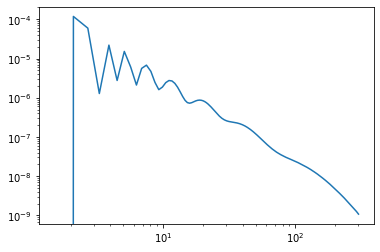

In [68]:
plt.plot(rad_hernq, field_hernq) 
plt.xscale('log')
plt.yscale('log')